# NVT Dynamics with Libra - 1 Electronic State

In this tutorial, we will perform dynamics in the NVT ensemlbe using Libra.

In the previous tutorial (NVE Dynamics with Libra, EXAMPLE 01), we performed dynamics in the NVE ensemble for a system with 1 and 2 electronic states. The electronic states were parabolas parameterized by the distance between two particles. For the system with 1 electronic state, the potential energy function was defined as

$$ \large{ V(d) = A d_0^2 } $$

Where d is the distance of the two particles, $ d_0 = q_0-q_1 $, and A is some scaling constant set by the user.

In this tutorial, we will move from dynamics in the NVE ensemble to that of the NVT ensemble.

Additionally, we will couple our 1-state quantum system to a linear chain of classical particles. The potential then takes the form

$$ \large{ V(d) = A d_0^2 + \sum_{k=1}^N V_m(d_k) } $$

Where $V_m(d_k) = a^2 (q_k - q_{k+1})^2 - a^3 (q_k - q_{k+1})^3 + a^4 (q_k - q_{k+1})^4 $


## Table of contents
1. [Define the Model Potentials](#Define_model)

    1a. [Define the 1-State Harmonic Potential](#1StateHO)  
    1b. [Setup Wrapper-like Function for Model Potentials](#Wrapper)  


2. [Define a Function to Handle the Dynamics](#Define_dynamics)  


3. [Run EXAMPLE 03 - 1 State Harmonic Potential, NVT Dynamics](#EXAMPLE03)

    3a. [EXAMPLE03 Analysis of Results](#03Analysis)  


4. [Compute Maxwell Boltzmann Distribution](#MaxwellBoltzmann)  

    4a. [EXAMPLE03 Analysis of Thermostat Properties](#03ThermoAnalysis)    


5. [Run EXAMPLE 04 - Define the 1-State Harmonic Potential with Linear Atom Chain, NVT Dynamics](#1StateHOwLC)


In [105]:
import sys
import cmath
import math
import os
import time

import numpy as np
import h5py
import matplotlib.pyplot as plt   # plots
#from matplotlib.mlab import griddata

if sys.platform=="cygwin":
    from cyglibra_core import *
elif sys.platform=="linux" or sys.platform=="linux2":
    from liblibra_core import *

from libra_py import units
import libra_py.models.Holstein as Holstein
from libra_py import tsh
from libra_py import tsh_stat
from libra_py import data_conv
from libra_py import data_stat
import libra_py.data_outs as data_outs
import libra_py.data_savers as data_savers
import libra_py.tsh as tsh
import libra_py.tsh_stat as tsh_stat

import libra_py.dynamics.tsh.compute as compute
import libra_py.dynamics.tsh.save as save
import libra_py.dynamics.tsh.plot as plot
#from libra_py import dynamics_hdf5
from libra_py import dynamics_plotting
#from libra_py import dynamics_exact
import util.libutil as comn


%matplotlib inline 

plt.rc('axes', titlesize=24)      # fontsize of the axes title
plt.rc('axes', labelsize=20)      # fontsize of the x and y labels
plt.rc('legend', fontsize=20)     # legend fontsize
plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
plt.rc('ytick', labelsize=16)    # fontsize of the tick labels

plt.rc('figure.subplot', left=0.2)
plt.rc('figure.subplot', right=0.95)
plt.rc('figure.subplot', bottom=0.13)
plt.rc('figure.subplot', top=0.88)

colors = {}

colors = {}
colors.update({"1": '#000000'})  # Black 
colors.update({"2": '#000099'})  # Blue  
colors.update({"3": '#006400'})  # Green 
colors.update({"4": '#990000'})  # Red   
colors.update({"5": '#8B008B'})  # Purple
colors.update({"6": '#FF8C00'})  # Orange
colors.update({"9": '#4d4d4d'})  # Gray  
color_index = ["1","2","3","4","5","6","9"]

## Define the Model Potentials <a name="Define_model"></a>

In this example, we have use only the model with 1 electronic state.  We will therefore call the function that defines this potential, harmonic_potential_1state(...)

The dots "..." refer to the arguments these functions will take, as shown below in the next cells.

In [106]:
class tmp:
    pass

### Define the 1-State Harmonic Potential <a name="1StateHO"></a>

In [107]:
def harmonic_potential_1state(q, params, full_id):
    """
    Potential energy function for a 1 state harmonic potential, based on a 2 particle system.
    This potential is defined in the adiabaitc basis.

    Args: 
        q ( MATRIX(1,1) ): coordinates of the particle, ndof = 1
        params ( dictionary ): model parameters

            * **params["A"]** ( double ): [ units: None ]

    Returns:       
        PyObject: obj, with the members:

            * obj.ham_dia ( CMATRIX(n,n) ): diabatic Hamiltonian 
            * obj.ovlp_dia ( CMATRIX(n,n) ): overlap of the basis (diabatic) states [ identity ]
            * obj.d1ham_dia ( list of 1 CMATRIX(n, n) objects ): 
                derivatives of the diabatic Hamiltonian w.r.t. the nuclear coordinate
            * obj.dc1_dia ( list of 1 CMATRIX(n, n) objects ): derivative coupling in the diabatic basis [ zero ]
    """

    Id = Cpp2Py(full_id)
    indx = Id[-1]
    
    critical_params = [] 
    default_params = { "A":0.01 }
    comn.check_input(params, default_params, critical_params)

    A = params["A"]
    N = q.num_of_rows
    
    Hadi = CMATRIX(1,1)
    u = CMATRIX(1,1)
    # d1ham and dc1_dia are ndia x ndia in dimension, but we have N of them
    d1ham_adi = CMATRIXList();
    dc1_adi   = CMATRIXList();
    for i in range(N):
        d1ham_adi.append( CMATRIX(1,1) )
        dc1_adi.append( CMATRIX(1,1) )        

    x0  = q.get(0,indx)
    x1  = q.get(1,indx)
    d0  = x0-x1
    E0  = A*d0*d0
    dE0 = 2.0*A*d0
    
    Hadi.set(0,0, E0*(1.0+0.0j) )
    d1ham_adi[0].set(0, 0,  dE0*(1.0+0.0j) )            
    d1ham_adi[1].set(0, 0, -dE0*(1.0+0.0j) )            

    u.set(0, 0, 1 * (1.0 + 0.0j))

    obj = tmp()
    obj.ham_adi   = Hadi    
    obj.d1ham_adi = d1ham_adi
    obj.dc1_adi   = dc1_adi
    obj.basis_transform = u
    
    return obj

### Define the 1-State Harmonic Potential with Linear Atom Chain <a name="1StateHOwLC"></a>

In [108]:
def harmonic_potential_1state_w_LC(q, params, full_id):
    """
    Potential energy function for a 1 state harmonic potential, based on a 2 particle system.
    This potential is defined in the adiabaitc basis. A linear chain of atoms is coupled to the potential.

    Args: 
        q ( MATRIX(1,1) ): coordinates of the particle, ndof = 1
        params ( dictionary ): model parameters

            * **params["A"]** ( double ): [ units: None ]
            * **params["a"]** ( double ):  [ units: bohr-1 ]
            * **params["V0]** ( double ):  [ units: Ha ]

    Returns:       
        PyObject: obj, with the members:

            * obj.ham_dia ( CMATRIX(n,n) ): diabatic Hamiltonian 
            * obj.ovlp_dia ( CMATRIX(n,n) ): overlap of the basis (diabatic) states [ identity ]
            * obj.d1ham_dia ( list of 1 CMATRIX(n, n) objects ): 
                derivatives of the diabatic Hamiltonian w.r.t. the nuclear coordinate
            * obj.dc1_dia ( list of 1 CMATRIX(n, n) objects ): derivative coupling in the diabatic basis [ zero ]
    """

    Id = Cpp2Py(full_id)
    indx = Id[-1]
    
    critical_params = [] 
    default_params = { "A":0.01, "a":0.25, "V0":0.06665  }
    comn.check_input(params, default_params, critical_params)

    A  = params["A"]
    a  = params["a"]
    V0 = params["V0"]
    a2 =  V0*a**2
    a3 = -V0*a**3
    a4 = 0.58*V0*a**4
    N = q.num_of_rows
    
    Hadi = CMATRIX(1,1)
    u = CMATRIX(1,1)
    d1ham_adi = CMATRIXList();
    dc1_adi   = CMATRIXList();
    for i in range(N):
        d1ham_adi.append( CMATRIX(1,1) )
        dc1_adi.append( CMATRIX(1,1) )        

    #==============================================    
    # Electronic states have the form:
    # V = A*d0*d0 + Sum_{k=1}^N ( Vm( d_k ) )
        
    #==============================================
    # Compute the term U_n = Sum_{k=1}^N ( U( q_k - q_k+1 ) )
    Un  = 0.0
    dUn = [] 
    for i in range(N-1):
        x1 = q.get(i, indx)
        x2 = q.get(i+1, indx)
        d = x1 - x2
        d2 = d*d
        d3 = d2*d
        d4 = d3*d
        Un += a2*d2 + a3*d3 + a4*d4
        dU_i = (2.0*a2*d + 3.0*a3*d2 + 4.0*a4*d3) 
        dUn.append(dU_i)            
        
    #==============================================
    # Compute the term  A * d0 * d0
    x1_quant = q.get(0, indx)
    x2_quant = q.get(1, indx)
    d_quant  = x1_quant - x2_quant
    E_quant  = A*d_quant*d_quant
    dE_quant = 2.0*A*d_quant 
        
    #==============================================
    # Construct the Hamiltonian
    Hadi.set(0,0, (E_quant + Un) * (1.0+0.0j) )
    d1ham_adi[0].set(0, 0, ( dE_quant + dUn[0] ) * (1.0+0.0j) )            
    for i in range(1, N-1):
        if i == 1:
            d1ham_adi[i].set(0, 0, ( -dE_quant + dUn[i] - dUn[i-1] ) * (1.0+0.0j) )            
        else:
            d1ham_adi[i].set(0, 0, ( dUn[i] - dUn[i-1] ) * (1.0+0.0j) )
    d1ham_adi[N-1].set(0, 0, -dUn[N-2]*(1.0+0.0j) )            
    
    u.set(0, 0, 1 * (1.0 + 0.0j))

    obj = tmp()
    obj.ham_adi   = Hadi    
    obj.d1ham_adi = d1ham_adi
    obj.dc1_adi   = dc1_adi
    obj.basis_transform = u
    
    return obj


### Setup Wrapper-like Function for Model Potentials <a name="Wrapper"></a>

Overtime, it has become convenient to define a light wrapper-like function to help organize the various model potentials. An example of this function is given in the following cell


In [109]:
def compute_model(q, params, full_id):

    model = params["model"]
    res = None
    
    if model==1:
        res = harmonic_potential_1state(q, params, full_id)

    elif model==2:
        res = harmonic_potential_1state_w_LC(q, params, full_id)

        
    return res

## Define a Function to Handle the Dynamics <a name="Define_dynamics"></a>

In the following cell, we define a function that will handle the computation of the dynamics. This can also be thought of as a light wrapper-like function to the dynamics itself. As we run multiple simulations later, it will become apparent how the existance of this functions helps keep things neat.

In this function, there is a default dynamics parameters dictionary. Below is a breif overview of the parameters listed in this dictionary. Later, we will set simulation specific parameters, which will overwrite some of these defaul parameter values. Some of the parameters convered below may be convered again in later sections. 

### Breif overview of pertinent parameters

* `rep_tdse` - The representation in which we want to integrate the schrodinger equation. 0 = diabatic, 1 = adiabatic

* `rep_ham` - The representation in which we define the Hamiltonian. 0 = diabatic, 1 = adiabatic

* `force_method` 1 - how to compute forces acting on the nuclei. This option (1) implies just the adiabatic forces of the active states - as prescribed by the TSH algorithms. Note that if it is used in conjunctions with the "tsh_method":-1, one gets a state-specific adiabatic dynamics.

* `nac_update_method` 1 - how to update the NACs used in the calculations of the vibronic Hamiltonians. This option (1) calls for its explicit evaluation using derivative coupling vectors and nuclear momenta. In the NBRA cases, it is set to (0), which means that this property is not re-computed. This re-computation is not really needed since the vibronic Hamiltonians are already passed to the nHamiltonian object via the read files. For the cases considered herein, we use 1 for both cases, even though EXAMPLE 01 case has 1 electronic state.

* `vel_rescale_opt` (-1) - how to rescale velocities of nuclei after sucessfull hops. The current option (-1) turns of the velocity rescaling. This is consistent with the notion that we are not doing just the adiabatic dynamics (no "live" electronic state switching). In the NBRA, this option is used, because the electronic state switching is done independent of the nuclear dynamics

* `entanglement_opt:0, ETHD3_alpha:0.0, ETHD3_beta:0.0` - Keep these options to 0 for now. They have not recently been updated but may be in the near future. They are parameters in methodologies to incorperate quantum nuclear effects. 

* `ensemble` - flag for which dynamics ensemble to run. 0 corresponds to the NVE ensemble, 1 corresponds to the NVT ensemble.

* `thermostat_params` - To be used when the parameter ensemble is set to 1. For NVE dynamics, one does not use a thermostat.

* `init_nucl` - dictionary with parameters for the initialization of nuclear degrees of freedeom. The option 3 corresponds to sampling initial positions and momenta from the normal distribution. The force_constant parameter relates to the width of such distribution. the value ntraj indicates for how many trajectories this will be done for. For a more in-depth account of the parameters in `init_nucl`, please see [here](https://github.com/bsmith24/libra-code/blob/devel/src/libra_py/dynamics/tsh/compute.py).

* `_init_elec` - The option 0 sets the initial electronic population to that define by the list istate. The first element of this list corresponds to the representation of the electronic wavefunction. 0 = diabatic, 1 = adiabatic. The second element of this list corresponds to the initial electronic state of the system. For a more in-depth account of the parameters in `_init_elec`, please see [here](https://github.com/bsmith24/libra-code/blob/devel/src/libra_py/dynamics/tsh/compute.py).



In [110]:
def run_tsh(common_params, model_params, prefix):
    
    params = dict(common_params)
        
    
    # Random numbers generator object
    rnd = Random()
    
    #============ Initialize dynamical variables ==================
    x0 = params["x0"]
    p0 = params["p0"]
    masses = params["masses"]
    k0     = params["k"]
    ndofs  = len(x0)
    ntraj  = params["ntraj"]
    nstates = params["nstates"]
 
    # Nuclear
    init_nucl = {"init_type":2, "force_constant":k0, "ntraj":ntraj}
    q, p, iM = compute.init_nuclear_dyn_var(x0, p0, masses, init_nucl, rnd)
    
    # Electronic
    istate = params["istate"]
    istates = []
    for i in range(nstates):
        istates.append(0.0)
    istates[ istate[1] ] = 1.0    
    _init_elec = { "init_type":0, "nstates":nstates, "istates":istates, "rep":istate[0],  "ntraj":ntraj   }

    
    #============= Dynamical variables ==============
    DR = MATRIX(nstates,nstates)
    AG = MATRIX(nstates,nstates)


    properties_to_save = [ "timestep", "time", "Ekin_ave", "Epot_ave", "Etot_ave", "Etherm", "E_NHC", 
                          "dEkin_ave", "dEpot_ave", "dEtot_ave", "states", "SH_pop", "SH_pop_raw",
                           "D_adi", "D_adi_raw", "D_dia", "D_dia_raw", "q", "p", "Cadi", "Cdia", 
                           "hvib_adi", "hvib_dia", "St", "basis_transform", "projector"
                        ]     
    
    
    dyn_params = dict(common_params)
    
    # This should update only the properties that aren't defined, but not override the existing values!
    critical_params = [  ] 
    default_params = { "rep_tdse":1, "rep_ham":1, "rep_sh":1, "rep_lz":0, "tsh_method":-1,
                   "force_method":1, "nac_update_method":0, "rep_force":1,
                   "hop_acceptance_algo":20, "momenta_rescaling_algo":201,
                   "use_boltz_factor":0, "Temperature":300.0, "do_reverse":1, "vel_rescale_opt":-1,
                  
                   "do_phase_correction":0, "tol":1e-3,                  
                   "state_tracking_algo":0, "MK_alpha":0.0, "MK_verbosity":0, 
                                                
                   "entanglement_opt":0, "ETHD3_alpha":0.0, "ETHD3_beta":0.0, 
                   "decoherence_algo":-1, "decoherence_rates":DR,
                   "decoherence_times_type":0, "decoherence_C_param":1.0, 
                   "decoherence_eps_param":0.1, "dephasing_informed":0,
                   "ave_gaps":AG, "instantaneous_decoherence_variant":1, "collapse_option":0,

                   "ensemble":1, 
                   "thermostat_params":{ "thermostat_type":"Nose-Hoover", 
                                         "Temperature":300.0,
                                         "NHC_size":5,
                                         "nu_therm":0.01,
                                       },
                      
                   "hdf5_output_level":-1, "prefix":prefix, "use_compression":0, "compression_level":[0,0,0], 
                   "mem_output_level":4, "txt_output_level":0, "properties_to_save": properties_to_save
                 } 
    
    comn.check_input(dyn_params, default_params, critical_params)
            
    _model_params = dict(model_params)
    _model_params.update({"model0": model_params["model"] })
    
    start = time.time()                               
    res = compute.generic_recipe(q, p, iM, dyn_params, compute_model, _model_params, _init_elec, rnd)
    end = time.time()    
    print(F"Calculation time = {end - start} seconds")
    return res 


## EXAMPLE 03 - 1 State Harmonic Potential, NVT Ensemble <a name="EXAMPLE03"></a>
### Setting Simulation Parameters

It is now time for us to set the simulation parameters. Below is a breif overview of the pertinent parameters.

* `ntraj` - number of copies of our system. In this case, this will correspond to how many copies of the two particle system we have

* `nsteps` - how many timesteps to take in the simulation. Each step is of size dt

* `dt` - size of each simulation step

* `nstates` - how many states are in the system. in other words, the dimensionality of the Hamiltonian

* `istate` - the first element of this list corresponds to the representation of the electronic wavefunction. Setting the first element of i state to 0 corresponds to the diabatic representation. Setting it to 1 corresponds to the adiabatic representation. The second element of this list corresponds to the initial electronic state of the system. 

* `which_(adi or dia)_states` - a list containing the indicies of the electronic states to be considered. The length of this list should match the dimensionality of the Hamiltonian

* `x0[i]` - The initial mean position of the trajectories ith degree of freedom. We have displaced it slighly to accentuate the potential's slope.

* `p0[i]`- The initial mean momentum of the trajectories ith degree of freedom

* `masses[i]` - The mass of the trajectories ith degree of freedom

* `k[i]` - The force constant of the trajectories ith degree of freedom. Used in the sampling of initial conditions.

* `ensemble` - flag for which dynamics ensemble to run. 0 corresponds to the NVE ensemble, 1 corresponds to the NVT ensemble. In this tutorial, we set this parameter to 1

* `thermostat_params` - To be used when the parameter ensemble is set to 1. For NVE dynamics, one does not use a thermostat. In this tutorial, we will be using this dictionary

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; `thermostat_type` - "Nose-Hoover", this initializes the Nose-Hoover thermostat. Currently, this is the only supported thermostat_type.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; `Temperature` - target temperature for the thermostate. Units are in Kelvin.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; `NHC_size` - Sets the number of Nose=Hoover chains to be coupled to the system.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; `nu_therm` - Sets the frequency at which the thermostat is coupled to the system. Units are in atomic units. For a guage, 0.0045563 Ha = 1000 cm-1

* `tsh_method` - how to handle surface hopping, the option -1 implies no hopping, that is the sole evolution on the PES

* `mem_output_level` - flag for how much data to output. Setting to 4 includes the trajectory resolved potential to be output in the HDF5 output file

* `rep_tsde` 1 - the TD-SE will be integrated in the adiabatic representation, meaning the wavefunction is assumed to be represented in the adiabatic basis and in terms of the corresponding (adiabatic rep.) amplitudes. 0 corresponds to the diabatic

* `rep_ham` 1 - the model Hamiltonian is defined in terms of adiabatic properties. 0 corresponds to the diabatic


In [111]:
# Set the prefix for the output file
prefix = "EXAMPLE03"

# Set the number of particles. This example has been formulated to have nparticles = 2
nparticles = 2

# Construct the dynamics parameters dicttionary
dyn_params = { "ntraj":1, "nsteps":100000, "dt":1.0, 
                    
                "nstates":1, "istate":[1, 0],   
                "which_adi_states":[0], "which_dia_states":[0],

                "x0":[0.0 for i in range(nparticles)],
                "p0":[0.0 for i in range(nparticles)], 
                "masses":[2000 for i in range(nparticles)],
                "k":[0.2 for i in range(nparticles)],                                
                "prefix":prefix,                 

                "ensemble": 1,
                "thermostat_params":{ "thermostat_type":"Nose-Hoover", 
                                      "Temperature":300.0,
                                      "NHC_size":10,
                                      "nu_therm":0.0045563,
                                    },
             } 

# Further update the dynamics parameters dicttionary
dyn_params.update( {"tsh_method":-1, "force_method":1, "nac_update_method":1, "vel_rescale_opt":-1, 
                    "mem_output_level":4, "hdf5_output_level":-1, "use_compression":0, 
                    "compression_level":[0,0,0],
                    "rep_tdse":1, "rep_ham":1 } 
                 )

# Make a dictionary for the model specific parameters
model_params = {"model":1, "A":0.02}
res = run_tsh(dyn_params, model_params, prefix)

 step= 0
 step= 10000
 step= 20000
 step= 30000
 step= 40000
 step= 50000
 step= 60000
 step= 70000
 step= 80000
 step= 90000
In mem_saver.save_data()
data_name =  ['timestep', 'time', 'Ekin_ave', 'Epot_ave', 'Etot_ave', 'Etherm', 'E_NHC', 'dEkin_ave', 'dEpot_ave', 'dEtot_ave', 'states', 'SH_pop', 'SH_pop_raw', 'D_adi', 'D_adi_raw', 'D_dia', 'D_dia_raw', 'q', 'p', 'Cadi', 'Cdia', 'hvib_adi', 'hvib_dia', 'St', 'basis_transform', 'projector']
keywords =  ['timestep', 'time', 'Ekin_ave', 'Epot_ave', 'Etot_ave', 'Etherm', 'E_NHC', 'dEkin_ave', 'dEpot_ave', 'dEtot_ave', 'states', 'SH_pop', 'SH_pop_raw', 'D_adi', 'D_adi_raw', 'D_dia', 'D_dia_raw', 'q', 'p', 'Cadi', 'Cdia', 'hvib_adi', 'hvib_dia', 'St', 'basis_transform', 'projector']
keys =  dict_keys(['timestep', 'time', 'Ekin_ave', 'Epot_ave', 'Etot_ave', 'dEkin_ave', 'dEpot_ave', 'dEtot_ave', 'Etherm', 'E_NHC', 'states', 'SH_pop', 'SH_pop_raw', 'D_adi', 'D_adi_raw', 'D_dia', 'D_dia_raw', 'q', 'p', 'Cadi', 'Cdia', 'hvib_adi', 'hvib_dia', '

/util/common/python/ondemand-jupyter/py36/anaconda-5.2.0/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


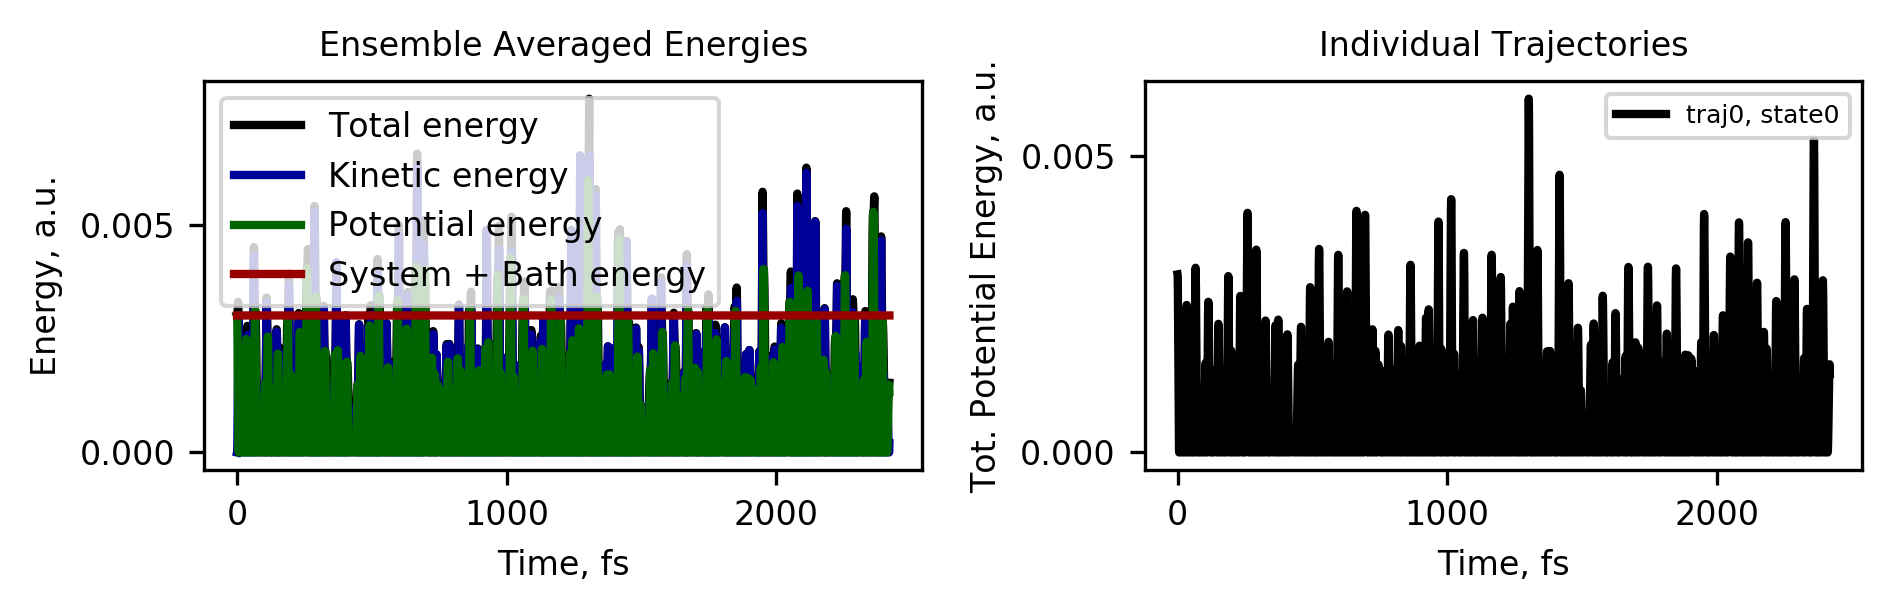

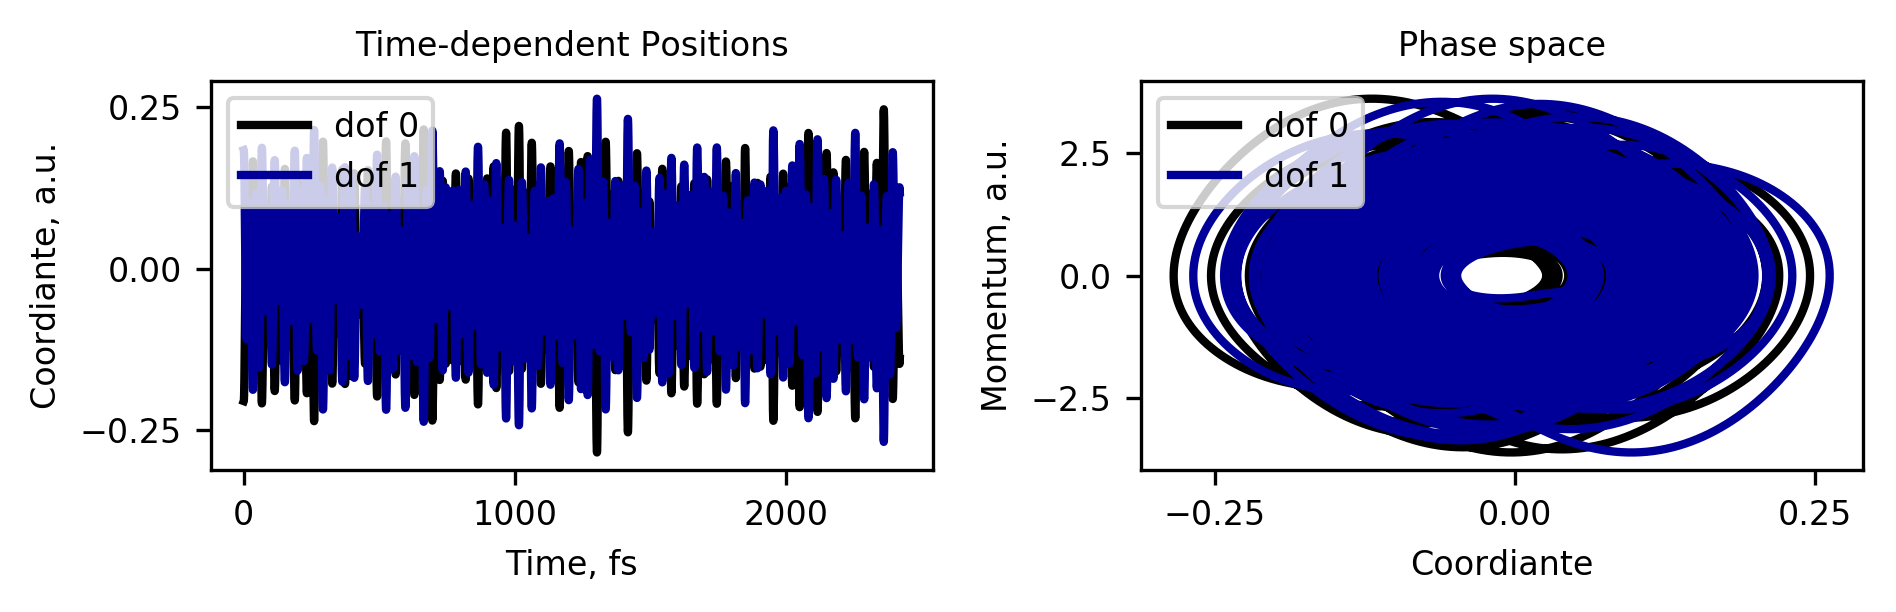

In [112]:
plot_params = { "prefix":prefix, "filename":"mem_data.hdf", "output_level":3,
                "which_trajectories":[i for i in range(dyn_params["ntraj"])], 
                "which_dofs":[0,1],
                "which_adi_states":[0], "which_dia_states":[0] }

filename           = plot_params["filename"]
prefix             = plot_params["prefix"]
output_level       = plot_params["output_level"]
which_dofs         = plot_params["which_dofs"]
which_trajectories = plot_params["which_trajectories"]
which_adi_states   = plot_params["which_adi_states"]
which_dia_states   = plot_params["which_dia_states"]
out_prefix = prefix

with h5py.File(F"{prefix}/{filename}", 'r') as f:

    #============================================
    # Figure 1 - Energy Components vs. Time
    plt.figure(num=None, figsize=(6.42, 2.14), dpi=300, edgecolor='black', frameon=True)
    plt.subplot(1,2,1)
    plt.title('Ensemble Averaged Energies', fontsize=8)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    #plt.ylim(0,0.006)
    plt.xlabel('Time, fs', fontsize=8)
    plt.ylabel('Energy, a.u.', fontsize=8)
    plt.plot(f["time/data"][:]/units.fs2au, f["Etot_ave/data"][:], label="Total energy",     linewidth=2, color = colors["1"])     
    plt.plot(f["time/data"][:]/units.fs2au, f["Ekin_ave/data"][:], label="Kinetic energy",   linewidth=2, color = colors["2"])                 
    plt.plot(f["time/data"][:]/units.fs2au, f["Epot_ave/data"][:], label="Potential energy", linewidth=2, color = colors["3"])                 
    plt.plot(f["time/data"][:]/units.fs2au, f["E_NHC/data"][:],    label="System + Bath energy", linewidth=2, color = colors["4"])                 
    plt.legend(fontsize=8)
    plt.tight_layout()

    # Figure 2 - Trajectory Energies
    ntraj = f["hvib_adi/data"].shape[1] 
    nadi  = f["hvib_adi/data"].shape[2] 
    ndia  = f["hvib_dia/data"].shape[2] 
    #============== Adiabatic energies =============
    plt.subplot(1,2,2)            
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.title('Individual Trajectories', fontsize=8)        
    #plt.ylim(-0.01,0.02)
    plt.xlabel('Time, fs', fontsize=8)        
    plt.ylabel('Tot. Potential Energy, a.u.', fontsize=8)
    indx = -1
    for istate in range(nadi):
        if istate in which_adi_states:
            indx = indx + 1
            for tr in range(ntraj):
                if tr in which_trajectories:                                    
                    plt.plot(f["time/data"][:]/units.fs2au, f["hvib_adi/data"][:, tr, istate, istate], label="traj"+str(tr)+", state"+str(istate), linewidth=2, color = colors[ color_index[indx] ])                 
    plt.legend(fontsize=6)
    plt.tight_layout()
    
    #============================================
    plt.figure(num=None, figsize=(6.42, 2.14), dpi=300, edgecolor='black', frameon=True)
    plt.subplot(1,2,1)
    # Figure 3 - Coordinate Information
    ntraj = f["q/data"].shape[1]
    ndof  = f["q/data"].shape[2]      
    # Time-dependent Positions
    plt.title('Time-dependent Positions', fontsize=8)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.xlabel('Time, fs', fontsize=8)
    plt.ylabel('Coordiante, a.u.', fontsize=8)        
    indx = -1
    for idof in range(ndof):
        if idof in which_dofs:
            indx = indx + 1
            for tr in range(ntraj):
                if tr in which_trajectories:
                    plt.plot(f["time/data"][:]/units.fs2au, f["q/data"][:, tr, idof], label="dof "+str(idof), linewidth=2, color = colors[ color_index[indx] ]) 
    plt.legend(fontsize=8)
    plt.tight_layout()
    
    #============================================
    plt.subplot(1,2,2)
    # Figure 4 - Phase space
    ntraj = f["q/data"].shape[1]
    ndof  = f["q/data"].shape[2]      
    # Time-dependent Positions
    plt.title('Phase space', fontsize=8)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.xlabel('Coordiante', fontsize=8)
    plt.ylabel('Momentum, a.u.', fontsize=8)        
    indx = -1
    for idof in range(ndof):
        if idof in which_dofs:
            indx = indx + 1
            for tr in range(ntraj):
                if tr in which_trajectories:
                    plt.plot(f["q/data"][:, tr, idof], f["p/data"][:, tr, idof], label="dof "+str(idof), linewidth=2, color = colors[ color_index[indx] ]) 
    plt.legend(fontsize=8)
    plt.tight_layout()
    plt.show()
    

### EXAMPLE 03 - Analysis of Results<a name="03Analysis"></a>

The top left figure corresponds to the trajectory ensembled kinetic, potential, and total energies. Given that the dynamics is done in the NVT ensemble, the conservation of total energy is not longer required. Instead, the total energy plus the energy of the thermostat is the conserved quantity (red line) It is observed that this property is well conserved.

The top right figure corresponds to the trajectory resolved total potential energy. In our setup, we considered only a sinlge trajectory (a single copy of our 2-particle system), so we will observe the total potential energies for only this one trajectory. Furthermore, out model is constructed such that the potential energy of the trajectory is the total potential energy of the system. For more complicated systems, this may not be the case.

The bottom left figure corresponds to the time-dependant position coordinates of each trajectory in our ensemble. Given that we have only 1 trajectory, we see only the position coordinates information of one set of degrees of freedom. In this case, we see the position coordinates for the first and second degrees of freedom (the two 1-dimensional particles) that comprise our system.

The bottom right figure corresponds to the phase space of our trajectory ensemble. Its degree of freedom resolved data follows analogously with the bottom left figure. 

## Compute Maxwell Boltzmann Distribution<a name="MaxwellBoltzmann"></a>

We will now compare the distribution of the velocities of a particle in our system to that of the [Maxwell-Boltzmann Distribution](https://en.wikipedia.org/wiki/Maxwell%E2%80%93Boltzmann_distribution) for our system.


We start with the generalized Maxwell Boltzmann Distribution for n-dimensions. As seen in the link provided, most of the derivation is done for us. We just need to compute the normalization constant.

Starting with the expression for the n-dimensional speed distribution

$$ \large{ F(v) dv =  Const * exp(-\frac{mv^2}{2k_BT}) * v^{n-1} dv} \,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,(1)$$    

Where n and m are the number of degrees of freedom and mass of the system of which one wishes to compute the statistics of, respectively. Integration of both sides yields (details present in the link provided above)

$$ \large{ \int_{0}^\infty F(v) dv = Const * [\frac{2k_BT}{m}]^{\huge{\frac{a+1}{2}} } \frac{ \Gamma{(\frac{a+1}{2})} }{2}} \,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\, (2)$$


Where, $a = n-1$. Applying the normalization condiiton and solving for Const yields:


$$ \large{ Const = \frac{1} {[\frac{2k_BT}{m}]^{\huge{\frac{a+1}{2}} } \frac{ \Gamma{(\frac{a+1}{2})} }{2}}} \,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\, (3)$$

We can then plug the result (3) into (1) to get each point in our analytical probability distribution. 

In the cell belows, we define a grid of velcoity values and compute (1) for each of the values. In this example, we compute the probability distribution for one of our particles. Therefore, the mass term will be the mass of this particle, and the dimensionality term will be the dimension of this particle.

In [113]:
# Define a velocity grid for our particle. Velocity is to be in atomic units, bohr / a.u.

# Set the index of the particle we want to analyze. In this example, it can be either 0 or 1. 
dof_index = [1]
mass = dyn_params["masses"][dof_index[0]]
ndof = len(dof_index)

# Make the velocity grid (atomic units)
dv = 0.000002
v_grid = np.array( [ dv*i for i in range(2500) ] )

# Compute f(v)dv
mwbz_dist = []
T = dyn_params["thermostat_params"]["Temperature"]
for i in range(len(v_grid)):
  
    # Get the velocity for the current grid point
    vel  = v_grid[i]

    # Recall that we have terms like (a+1)/2. Since a = n-1, we can just use (n/2),
    # where n is the dimensionality of the system we wish to get the statistics of.
    dim_factor = ndof*0.5

    # Compute the Const term    
    const_term1 = ( 2.0*units.kB*T / mass ) ** ( dim_factor )
    const_term2 = 0.5*math.gamma( dim_factor )
    const = 1.0 / (const_term1 * const_term2)
    
    # Compute the exponential term
    exponential = math.exp( - 0.5 * mass * vel * vel / ( units.kB * T ) )
    
    # Compute the final term
    v_power = vel**(ndof-1)

    # Combine terms
    mwbz_dist.append(const * exponential * v_power)   

print ("Sum of MWBZ distribution is ", sum(mwbz_dist)*dv)

# Normalize mwbz_dist
mwbz_dist = np.array(mwbz_dist)
mwbz_dist /= mwbz_dist.max()

#=============================================
# Compute velocity distribution from MD
# We already have our momenta informaiton - get for one of the particles
p_idof = []
with h5py.File(F"{prefix}/{filename}", 'r') as f:
    p_idof = f["p/data"][:, 0, dof_index[0]][:]  
    
X = []
for step in range(dyn_params["nsteps"]):
    x = CMATRIX(1,1)
    x.set(0,0,abs(p_idof[step]/mass))
    X.append(x)
bin_support, dens, cum = data_stat.cmat_distrib(X, 0, 0, 0, v_grid.min(), v_grid.max(), dv)
v_dist = np.array([i for i in dens])
print ("Sum of MD velocity distribution is ", sum(v_dist)*dv)
v_dist /= v_dist.max()


Sum of MWBZ distribution is  1.0011576654569054
Sum of MD velocity distribution is  0.9999899999980701


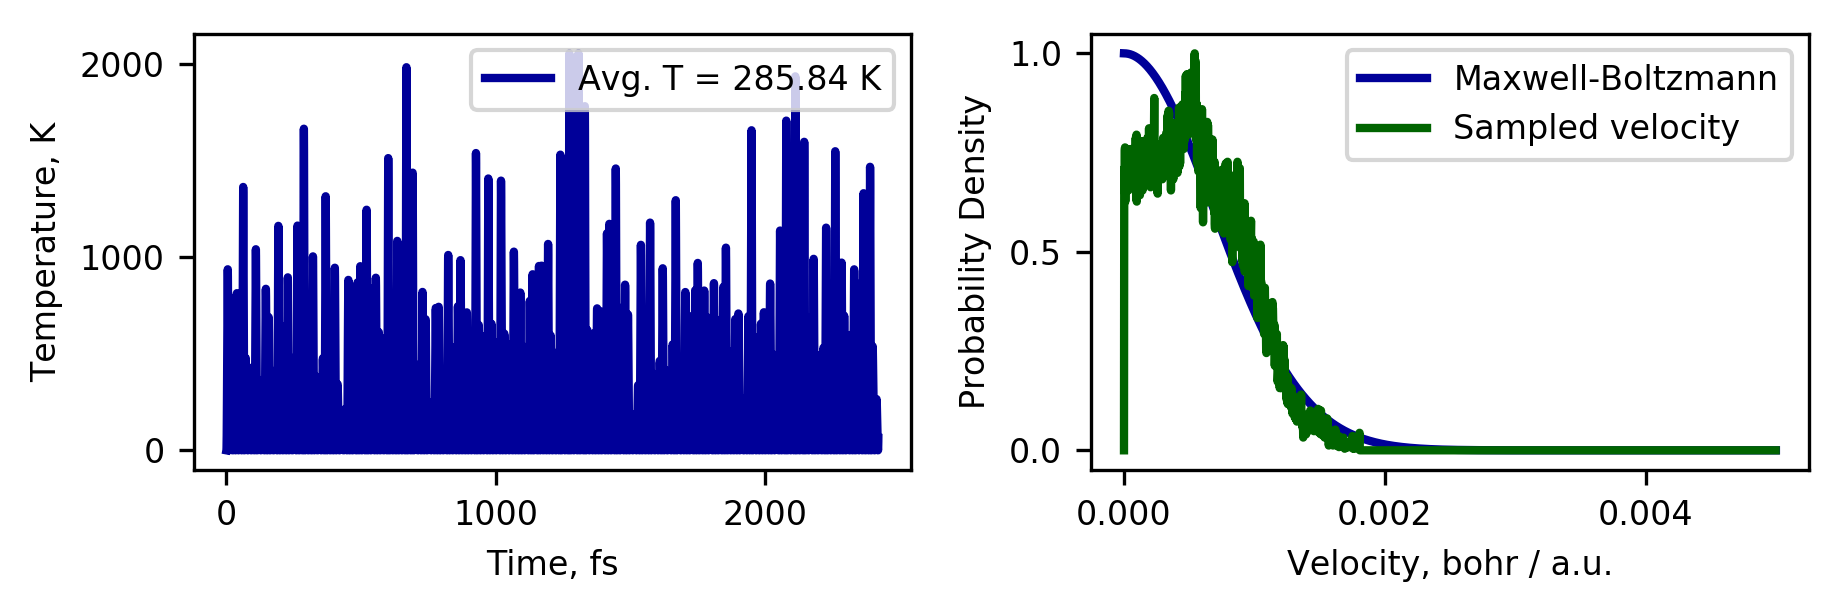

In [114]:
plot_params = { "prefix":prefix, "filename":"mem_data.hdf", "output_level":3,
                "which_trajectories":range(200), "which_dofs":[0,1],
                "which_adi_states":[0,1], "which_dia_states":[0,1] }

filename           = plot_params["filename"]
prefix             = plot_params["prefix"]
output_level       = plot_params["output_level"]
which_dofs         = plot_params["which_dofs"]
which_trajectories = plot_params["which_trajectories"]
which_adi_states   = plot_params["which_adi_states"]
which_dia_states   = plot_params["which_dia_states"]
out_prefix = prefix

with h5py.File(F"{prefix}/{filename}", 'r') as f:

    # Figure 1 - Energy Components vs. Time
    plt.figure(num=None, figsize=(6.24, 2.14), dpi=300, edgecolor='black', frameon=True)
    plt.subplot(1,2,1)
    plt.title('')
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    #plt.ylim(0,1000)
    #plt.xlim(150,200)
    plt.xlabel('Time, fs', fontsize=8)
    plt.ylabel('Temperature, K', fontsize=8)
    Temp = f["Ekin_ave/data"][:] * ( 2.0 / nparticles ) * (1.0/units.kB)
    temp = sum(Temp)/len(Temp)
    plt.plot(f["time/data"][:]/units.fs2au, Temp, label="Avg. T = "+str(round(temp,2))+" K", linewidth=2, color = colors["2"])                            
    plt.legend(fontsize=8)

    plt.subplot(1,2,2)
    plt.title('')
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    #plt.ylim(0,700)
    #plt.xlim(150,200)
#    plt.xlabel('Velocity, Angstrom / fs', fontsize=8)
    plt.xlabel('Velocity, bohr / a.u.', fontsize=8)
    plt.ylabel('Probability Density',   fontsize=8)
    plt.plot(v_grid, mwbz_dist, label="Maxwell-Boltzmann", linewidth=2, color = colors["2"])    
    plt.plot(bin_support, v_dist,    label="Sampled velocity", linewidth=2, color = colors["3"])   
    plt.legend(fontsize=8)
    
    plt.tight_layout()
    plt.show()


### EXAMPLE 03 - Analysis of Thermostat Properties<a name="03ThermoAnalysis"></a>

The left figure shows the evolution of the temperature of the system. As expected, large swings in the temperature are observed, as our system is comprised of only two particles. The average temperature, however, is close to the target temperature of 300.0 K. 

The right figure compares the analytical Maxwell-Boltzmann distribution for our system (1 1-d particle of mass, m) with the distribution velocities of that particle as sampled from MD. It can be seen that the match between the two distributions is sufficient.

One way to reduce the fluctuation of our quantum system without increasing the number of particles in our quanutm system is to additionally couple the quanutm system to a classical one. In the following section, we consdier the dynamics of our 1-State 2 particle quantum system in 1-dimension with the system coupled to a linear chain of classical particles. 

## EXAMPLE 04

In [115]:
# Set the prefix for the output file
prefix = "EXAMPLE04"

# Set the number of particles. This example has been formulated to have nparticles = 2
nparticles = 20

# Construct the dynamics parameters dicttionary
dyn_params = { "ntraj":1, "nsteps":100000, "dt":1.0, 
                    
                "nstates":1, "istate":[1, 0],   
                "which_adi_states":[0], "which_dia_states":[0],

                "x0":[0.0 for i in range(nparticles)],
                "p0":[0.0 for i in range(nparticles)], 
                "masses":[2000 for i in range(nparticles)],
                "k":[0.2 for i in range(nparticles)],                                
                "prefix":prefix,                 

                "ensemble": 1,
                "thermostat_params":{ "thermostat_type":"Nose-Hoover", 
                                      "Temperature":300.0,
                                      "NHC_size":10,
                                      "nu_therm":0.0045563,
                                    },
             } 

# Further update the dynamics parameters dicttionary
dyn_params.update( {"tsh_method":-1, "force_method":1, "nac_update_method":1, "vel_rescale_opt":-1, 
                    "mem_output_level":4, "hdf5_output_level":-1, "use_compression":0, 
                    "compression_level":[0,0,0],
                    "rep_tdse":1, "rep_ham":1 } 
                 )

# Make a dictionary for the model specific parameters
model_params = {"model":2, "A":0.02}
res = run_tsh(dyn_params, model_params, prefix)

 step= 0
 step= 10000
 step= 20000
 step= 30000
 step= 40000
 step= 50000
 step= 60000
 step= 70000
 step= 80000
 step= 90000
In mem_saver.save_data()
data_name =  ['timestep', 'time', 'Ekin_ave', 'Epot_ave', 'Etot_ave', 'Etherm', 'E_NHC', 'dEkin_ave', 'dEpot_ave', 'dEtot_ave', 'states', 'SH_pop', 'SH_pop_raw', 'D_adi', 'D_adi_raw', 'D_dia', 'D_dia_raw', 'q', 'p', 'Cadi', 'Cdia', 'hvib_adi', 'hvib_dia', 'St', 'basis_transform', 'projector']
keywords =  ['timestep', 'time', 'Ekin_ave', 'Epot_ave', 'Etot_ave', 'Etherm', 'E_NHC', 'dEkin_ave', 'dEpot_ave', 'dEtot_ave', 'states', 'SH_pop', 'SH_pop_raw', 'D_adi', 'D_adi_raw', 'D_dia', 'D_dia_raw', 'q', 'p', 'Cadi', 'Cdia', 'hvib_adi', 'hvib_dia', 'St', 'basis_transform', 'projector']
keys =  dict_keys(['timestep', 'time', 'Ekin_ave', 'Epot_ave', 'Etot_ave', 'dEkin_ave', 'dEpot_ave', 'dEtot_ave', 'Etherm', 'E_NHC', 'states', 'SH_pop', 'SH_pop_raw', 'D_adi', 'D_adi_raw', 'D_dia', 'D_dia_raw', 'q', 'p', 'Cadi', 'Cdia', 'hvib_adi', 'hvib_dia', '

/util/common/python/ondemand-jupyter/py36/anaconda-5.2.0/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


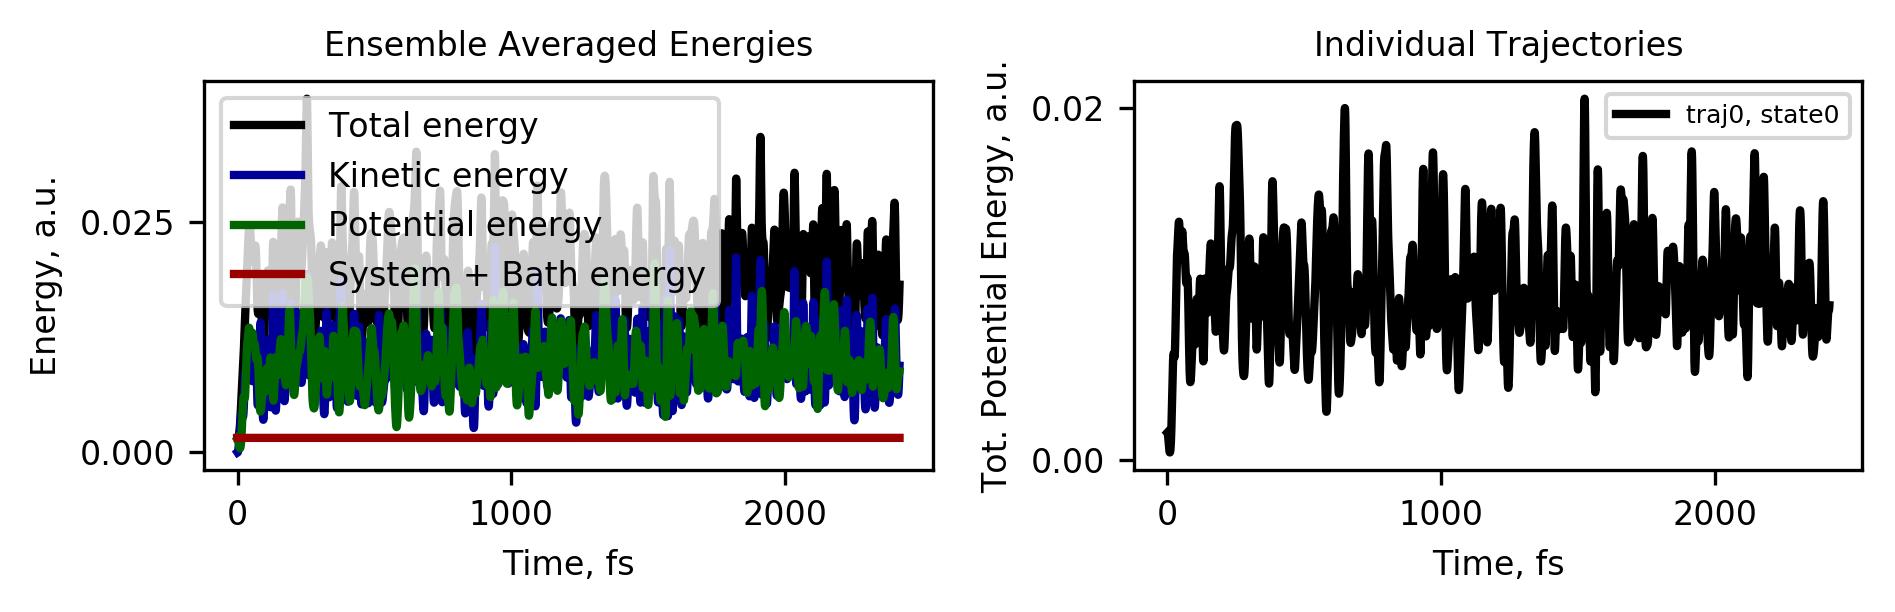

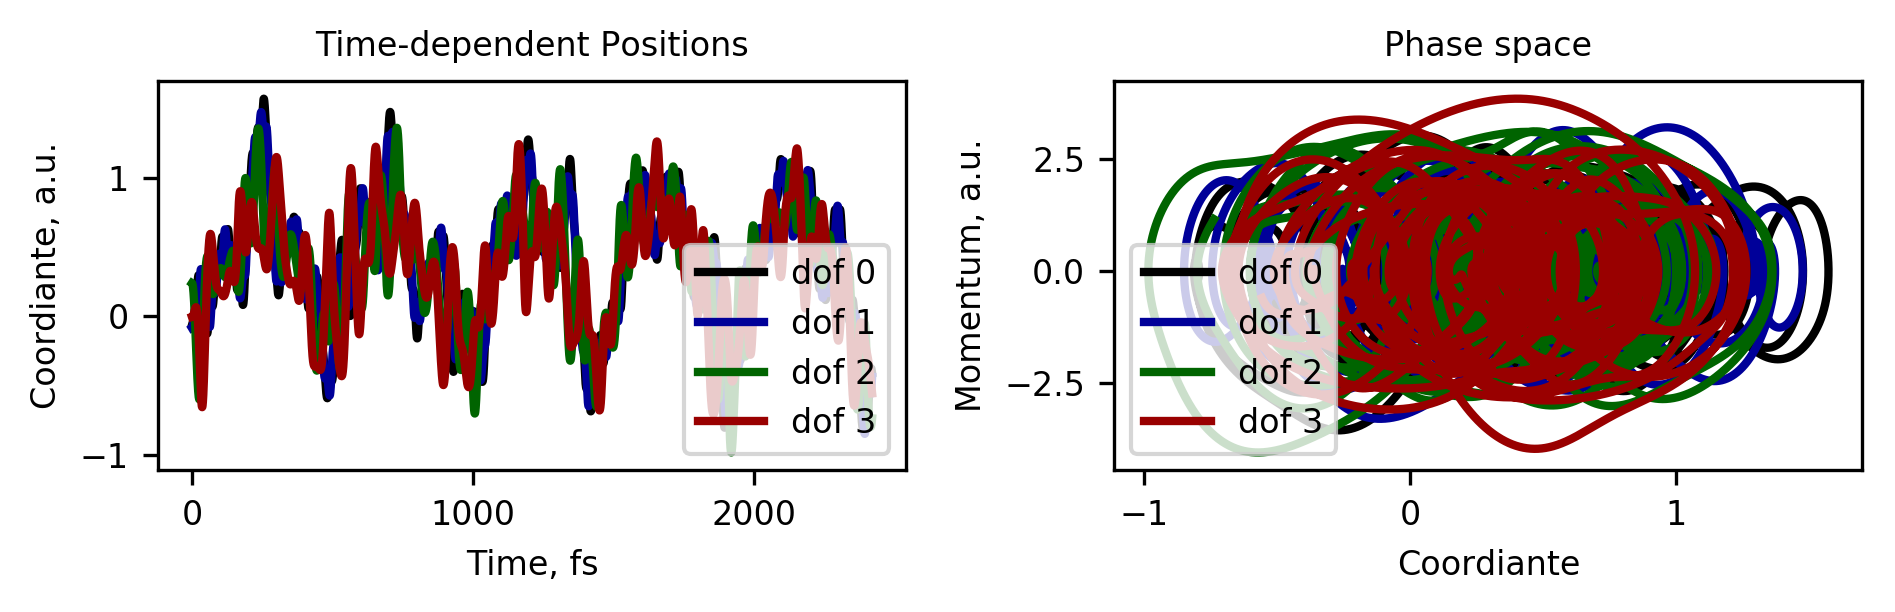

In [119]:
plot_params = { "prefix":prefix, "filename":"mem_data.hdf", "output_level":3,
                "which_trajectories":[i for i in range(dyn_params["ntraj"])], 
                "which_dofs":[0,1,2,3],
                "which_adi_states":[0], "which_dia_states":[0] }

filename           = plot_params["filename"]
prefix             = plot_params["prefix"]
output_level       = plot_params["output_level"]
which_dofs         = plot_params["which_dofs"]
which_trajectories = plot_params["which_trajectories"]
which_adi_states   = plot_params["which_adi_states"]
which_dia_states   = plot_params["which_dia_states"]
out_prefix = prefix

with h5py.File(F"{prefix}/{filename}", 'r') as f:

    #============================================
    # Figure 1 - Energy Components vs. Time
    plt.figure(num=None, figsize=(6.42, 2.14), dpi=300, edgecolor='black', frameon=True)
    plt.subplot(1,2,1)
    plt.title('Ensemble Averaged Energies', fontsize=8)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    #plt.ylim(0,0.006)
    plt.xlabel('Time, fs', fontsize=8)
    plt.ylabel('Energy, a.u.', fontsize=8)
    plt.plot(f["time/data"][:]/units.fs2au, f["Etot_ave/data"][:], label="Total energy",     linewidth=2, color = colors["1"])     
    plt.plot(f["time/data"][:]/units.fs2au, f["Ekin_ave/data"][:], label="Kinetic energy",   linewidth=2, color = colors["2"])                 
    plt.plot(f["time/data"][:]/units.fs2au, f["Epot_ave/data"][:], label="Potential energy", linewidth=2, color = colors["3"])                 
    plt.plot(f["time/data"][:]/units.fs2au, f["E_NHC/data"][:],    label="System + Bath energy", linewidth=2, color = colors["4"])                 
    plt.legend(fontsize=8)
    plt.tight_layout()

    # Figure 2 - Trajectory Energies
    ntraj = f["hvib_adi/data"].shape[1] 
    nadi  = f["hvib_adi/data"].shape[2] 
    ndia  = f["hvib_dia/data"].shape[2] 
    #============== Adiabatic energies =============
    plt.subplot(1,2,2)            
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.title('Individual Trajectories', fontsize=8)        
    #plt.ylim(-0.01,0.02)
    plt.xlabel('Time, fs', fontsize=8)        
    plt.ylabel('Tot. Potential Energy, a.u.', fontsize=8)
    indx = -1
    for istate in range(nadi):
        if istate in which_adi_states:
            indx = indx + 1
            for tr in range(ntraj):
                if tr in which_trajectories:                                    
                    plt.plot(f["time/data"][:]/units.fs2au, f["hvib_adi/data"][:, tr, istate, istate], label="traj"+str(tr)+", state"+str(istate), linewidth=2, color = colors[ color_index[indx] ])                 
    plt.legend(fontsize=6)
    plt.tight_layout()
    
    #============================================
    plt.figure(num=None, figsize=(6.42, 2.14), dpi=300, edgecolor='black', frameon=True)
    plt.subplot(1,2,1)
    # Figure 3 - Coordinate Information
    ntraj = f["q/data"].shape[1]
    ndof  = f["q/data"].shape[2]      
    # Time-dependent Positions
    plt.title('Time-dependent Positions', fontsize=8)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.xlabel('Time, fs', fontsize=8)
    plt.ylabel('Coordiante, a.u.', fontsize=8)        
    indx = -1
    for idof in range(ndof):
        if idof in which_dofs:
            indx = indx + 1
            for tr in range(ntraj):
                if tr in which_trajectories:
                    plt.plot(f["time/data"][:]/units.fs2au, f["q/data"][:, tr, idof], label="dof "+str(idof), linewidth=2, color = colors[ color_index[indx] ]) 
    plt.legend(fontsize=8)
    plt.tight_layout()
    
    #============================================
    plt.subplot(1,2,2)
    # Figure 4 - Phase space
    ntraj = f["q/data"].shape[1]
    ndof  = f["q/data"].shape[2]      
    # Time-dependent Positions
    plt.title('Phase space', fontsize=8)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.xlabel('Coordiante', fontsize=8)
    plt.ylabel('Momentum, a.u.', fontsize=8)        
    indx = -1
    for idof in range(ndof):
        if idof in which_dofs:
            indx = indx + 1
            for tr in range(ntraj):
                if tr in which_trajectories:
                    plt.plot(f["q/data"][:, tr, idof], f["p/data"][:, tr, idof], label="dof "+str(idof), linewidth=2, color = colors[ color_index[indx] ]) 
    plt.legend(fontsize=8)
    plt.tight_layout()
    plt.show()
    

In [117]:
# Define a velocity grid for our particle. Velocity is to be in atomic units, bohr / a.u.

# Set the index of the particle we want to analyze. In this example, it can be either 0 or 1. 
dof_index = [1]
mass = dyn_params["masses"][dof_index[0]]
ndof = len(dof_index)

# Make the velocity grid (atomic units)
dv = 0.000002
v_grid = np.array( [ dv*i for i in range(2500) ] )

# Compute f(v)dv
mwbz_dist = []
T = dyn_params["thermostat_params"]["Temperature"]
for i in range(len(v_grid)):
  
    # Get the velocity for the current grid point
    vel  = v_grid[i]

    # Recall that we have terms like (a+1)/2. Since a = n-1, we can just use (n/2),
    # where n is the dimensionality of the system we wish to get the statistics of.
    dim_factor = ndof*0.5

    # Compute the Const term    
    const_term1 = ( 2.0*units.kB*T / mass ) ** ( dim_factor )
    const_term2 = 0.5*math.gamma( dim_factor )
    const = 1.0 / (const_term1 * const_term2)
    
    # Compute the exponential term
    exponential = math.exp( - 0.5 * mass * vel * vel / ( units.kB * T ) )
    
    # Compute the final term
    v_power = vel**(ndof-1)

    # Combine terms
    mwbz_dist.append(const * exponential * v_power)   

print ("Sum of MWBZ distribution is ", sum(mwbz_dist)*dv)

# Normalize mwbz_dist
mwbz_dist = np.array(mwbz_dist)
mwbz_dist /= mwbz_dist.max()

#=============================================
# Compute velocity distribution from MD
# We already have our momenta informaiton - get for one of the particles
p_idof = []
with h5py.File(F"{prefix}/{filename}", 'r') as f:
    p_idof = f["p/data"][:, 0, dof_index[0]][:]  
    
X = []
for step in range(dyn_params["nsteps"]):
    x = CMATRIX(1,1)
    x.set(0,0,abs(p_idof[step]/mass))
    X.append(x)
bin_support, dens, cum = data_stat.cmat_distrib(X, 0, 0, 0, v_grid.min(), v_grid.max(), dv)
v_dist = np.array([i for i in dens])
print ("Sum of MD velocity distribution is ", sum(v_dist)*dv)
v_dist /= v_dist.max()


Sum of MWBZ distribution is  1.0011576654569054
Sum of MD velocity distribution is  0.9999899999980741


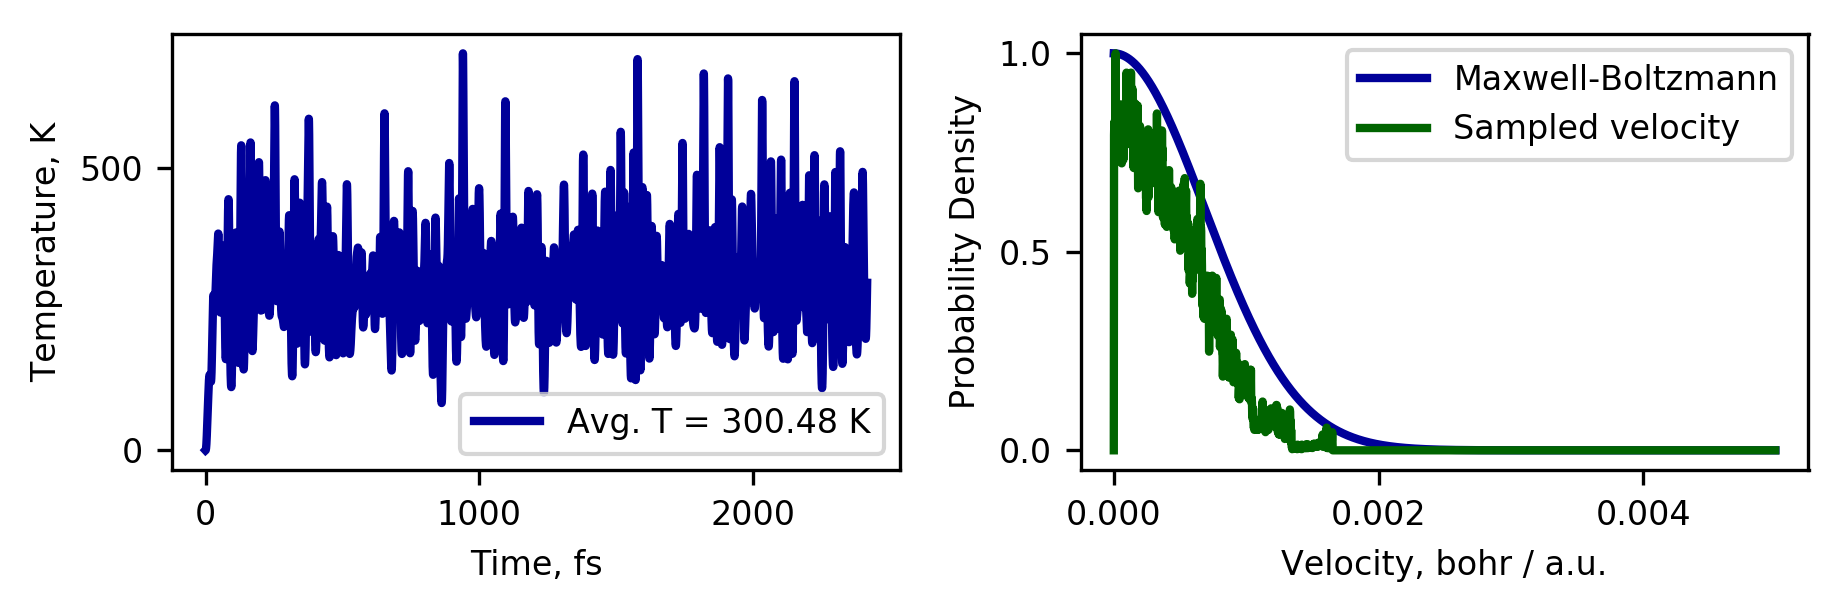

In [118]:
plot_params = { "prefix":prefix, "filename":"mem_data.hdf", "output_level":3,
                "which_trajectories":range(200), "which_dofs":[0,1,2,3,4,5],
                "which_adi_states":[0,1], "which_dia_states":[0,1] }

filename           = plot_params["filename"]
prefix             = plot_params["prefix"]
output_level       = plot_params["output_level"]
which_dofs         = plot_params["which_dofs"]
which_trajectories = plot_params["which_trajectories"]
which_adi_states   = plot_params["which_adi_states"]
which_dia_states   = plot_params["which_dia_states"]
out_prefix = prefix

with h5py.File(F"{prefix}/{filename}", 'r') as f:

    # Figure 1 - Energy Components vs. Time
    plt.figure(num=None, figsize=(6.24, 2.14), dpi=300, edgecolor='black', frameon=True)
    plt.subplot(1,2,1)
    plt.title('')
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    #plt.ylim(0,1000)
    #plt.xlim(150,200)
    plt.xlabel('Time, fs', fontsize=8)
    plt.ylabel('Temperature, K', fontsize=8)
    Temp = f["Ekin_ave/data"][:] * ( 2.0 / nparticles ) * (1.0/units.kB)
    temp = sum(Temp)/len(Temp)
    plt.plot(f["time/data"][:]/units.fs2au, Temp, label="Avg. T = "+str(round(temp,2))+" K", linewidth=2, color = colors["2"])                            
    plt.legend(fontsize=8)

    plt.subplot(1,2,2)
    plt.title('')
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    #plt.ylim(0,700)
    #plt.xlim(150,200)
#    plt.xlabel('Velocity, Angstrom / fs', fontsize=8)
    plt.xlabel('Velocity, bohr / a.u.', fontsize=8)
    plt.ylabel('Probability Density',   fontsize=8)
    plt.plot(v_grid, mwbz_dist, label="Maxwell-Boltzmann", linewidth=2, color = colors["2"])    
    plt.plot(bin_support, v_dist,    label="Sampled velocity", linewidth=2, color = colors["3"])   
    plt.legend(fontsize=8)
    
    plt.tight_layout()
    plt.show()
